In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from joblib import Parallel, delayed
from itertools import cycle
import numpy as np

# Загрузка набора данных
ev_data = pd.read_csv(r"Electric_Vehicle_Population_Data (2).csv")

In [2]:
# Проведение разведочного анализа данных (EDA)
print(ev_data.info())
print(ev_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177866 non-null  object 
 1   County                                             177861 non-null  object 
 2   City                                               177861 non-null  object 
 3   State                                              177866 non-null  object 
 4   Postal Code                                        177861 non-null  float64
 5   Model Year                                         177866 non-null  int64  
 6   Make                                               177866 non-null  object 
 7   Model                                              177866 non-null  object 
 8   Electric Vehicle Type                              177866 non-null  object

In [3]:
# Проверка на дубликаты
duplicates = ev_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [4]:
# Обработка пропущенных значений
cleaned_data = ev_data.fillna(ev_data.mean(numeric_only=True))
for column in cleaned_data.select_dtypes(include=['object', 'category']).columns:
    cleaned_data[column] = cleaned_data[column].fillna(cleaned_data[column].mode()[0])

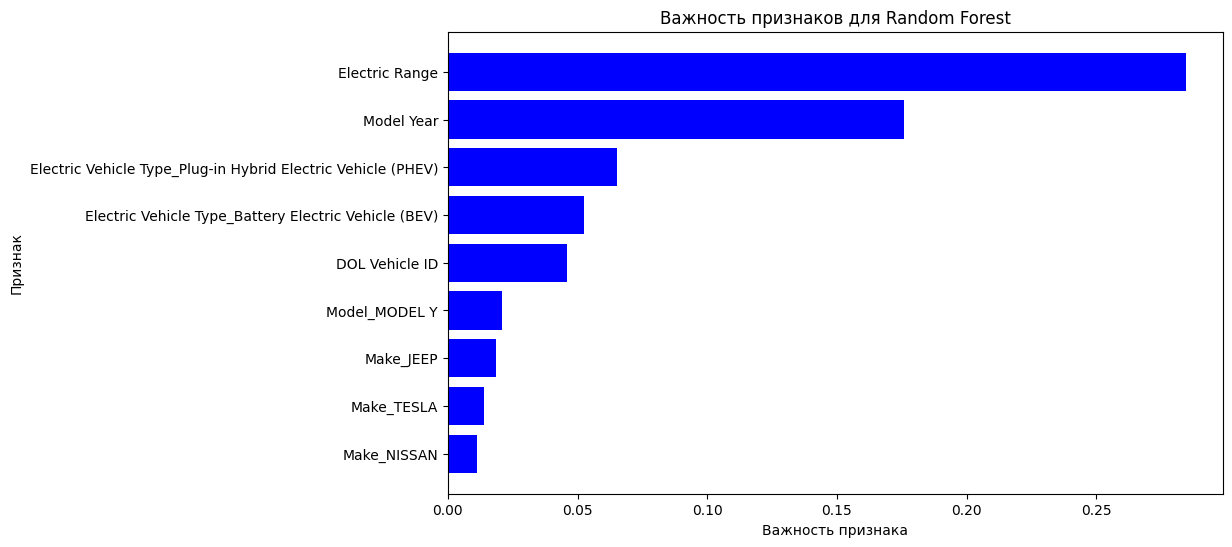

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Загрузите ваш набор данных
# df = pd.read_csv('your_dataset.csv')  # Разкомментируйте и измените эту строку, чтобы загрузить ваш набор данных

# Предположим, что ваш датафрейм называется df
# Определите признаки и целевую переменную
features = [
    'VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 
    'Model', 'Electric Vehicle Type', 'Electric Range', 'Base MSRP', 'Legislative District', 
    'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract'
]
target = 'Clean Alternative Fuel Vehicle (CAFV) Eligibility'

X = cleaned_data[features]
y = cleaned_data[target]

# Разделите данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определите конвейеры предобработки
numeric_features = ['Postal Code', 'Model Year', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', '2020 Census Tract']
categorical_features = ['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model', 'Electric Vehicle Type', 'Vehicle Location', 'Electric Utility']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Определите модель
model = RandomForestClassifier(random_state=42)

# Создайте и обучите конвейер
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', model)])
pipeline.fit(X_train, y_train)

# Функция для построения важности признаков
def plot_feature_importance(model, feature_names, model_name, threshold=0.01):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        
        # Фильтрация для отображения признаков с важностью выше порога
        feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > threshold]
        
        plt.figure(figsize=(10, 6))
        plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='b', align='center')
        plt.xlabel('Важность признака')
        plt.ylabel('Признак')
        plt.title(f'Важность признаков для {model_name}')
        plt.gca().invert_yaxis()
        plt.show()
    else:
        print(f"Модель {model_name} не поддерживает определение важности признаков.")

# Извлечение имен признаков
num_features = numeric_features
cat_features = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = list(num_features) + list(cat_features)

# Построение важности признаков
plot_feature_importance(model, all_features, 'Random Forest')



In [6]:
# Использование кодировки Label Encoding для кодирования категориальных столбцов
columns_to_encode = ['VIN (1-10)', 'County', 'City', 'State', 'Make', 'Model',
                     'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
                     'Vehicle Location', 'Electric Utility']

In [7]:
# Кодирование категориальных столбцов с использованием LabelEncoder
cleaned_data_encoded = cleaned_data.copy()
label_encoders = {column: LabelEncoder().fit(cleaned_data_encoded[column]) for column in columns_to_encode}
for column, le in label_encoders.items():
    cleaned_data_encoded[column] = le.transform(cleaned_data_encoded[column])

In [8]:
# Выбор важных признаков на основе анализа значимости признаков
selected_features = [
    'Electric Range', 'Model Year', 'Electric Vehicle Type', 
    'Model', 'Make', 'Base MSRP'
]

In [9]:
# Расчет матрицы корреляции
correlation_matrix = cleaned_data_encoded[selected_features + ['Clean Alternative Fuel Vehicle (CAFV) Eligibility']].corr()

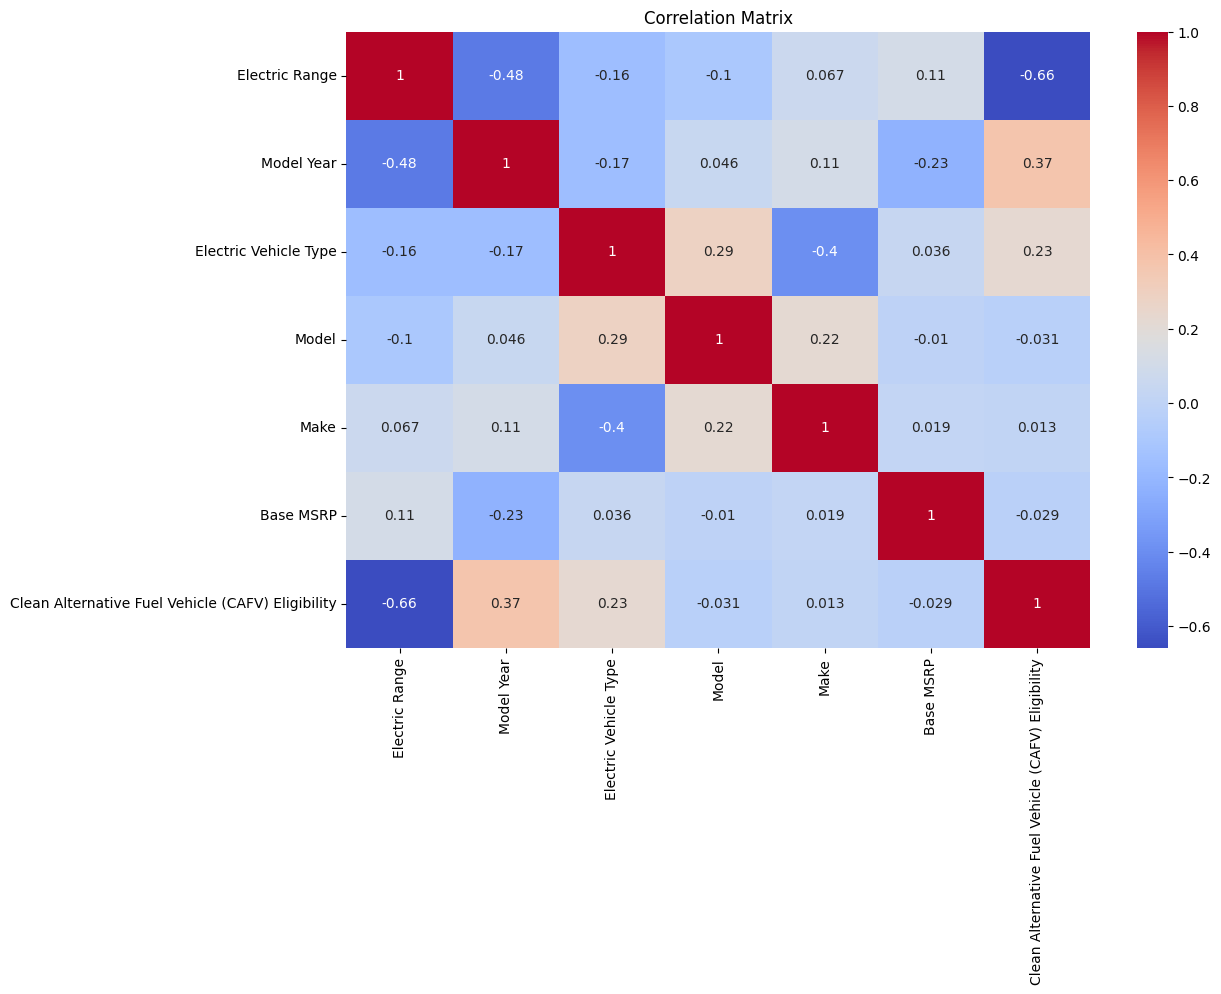

In [10]:
# Построение тепловой карты матрицы корреляции
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [11]:
# Использование меньшей выборки данных для обучения
sampled_data = cleaned_data_encoded.sample(frac=0.01, random_state=42)  # Reduced sample size to 1%

In [12]:
# Разделение данных на признаки и целевую переменную
X = sampled_data[selected_features]
y = sampled_data['Clean Alternative Fuel Vehicle (CAFV) Eligibility']

In [13]:
# Применение PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [14]:
# Повторное разделение данных на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

In [15]:
# Выбор признаков с использованием SelectKBest
selector = SelectKBest(f_classif, k=2)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [16]:
# Определение моделей с более простыми конфигурациями
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),  # Using a linear kernel to reduce complexity
    'KNN': KNeighborsClassifier(n_neighbors=3),  # Reducing the number of neighbors
    'XGBoost': XGBClassifier(max_depth=3, n_estimators=10),  # Further reduced depth and number of estimators
    'LightGBM': LGBMClassifier(max_depth=3, n_estimators=10)  # Further reduced depth and number of estimators
}

In [17]:
# Функция для построения матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [18]:
# Функция для оценки модели
def evaluate_model(model_name, model, X_train_selected, y_train, X_test_selected, y_test):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_selected, y_train, cv=cv)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test_selected)
    else:
        y_pred_proba = model.decision_function(X_test_selected)
        # Преобразование результата функции решений в вероятность
        y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min())
    return model_name, scores.mean(), y_pred, y_pred_proba

In [19]:
# Оценка всех моделей параллельно
results = Parallel(n_jobs=-1)(delayed(evaluate_model)(model_name, model, X_train_selected, y_train, X_test_selected, y_test) for model_name, model in models.items())

Cross-validation results:
Logistic Regression: 0.9988


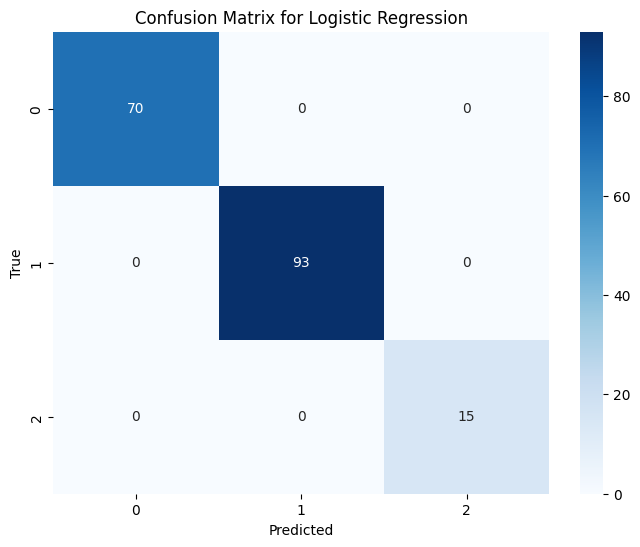

SVM: 0.9981


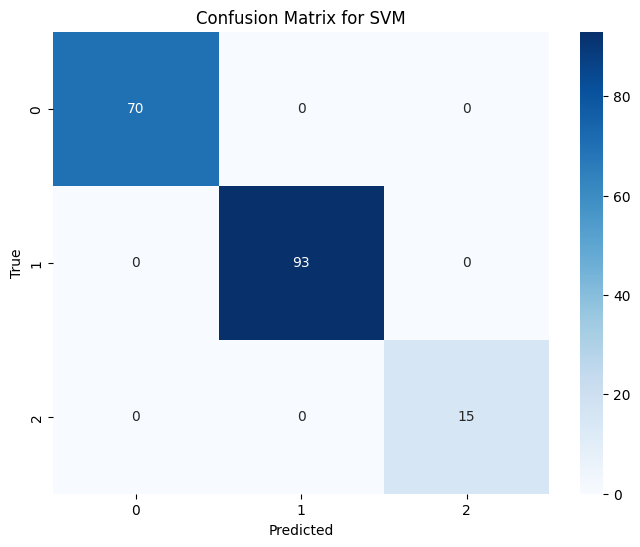

KNN: 0.9975


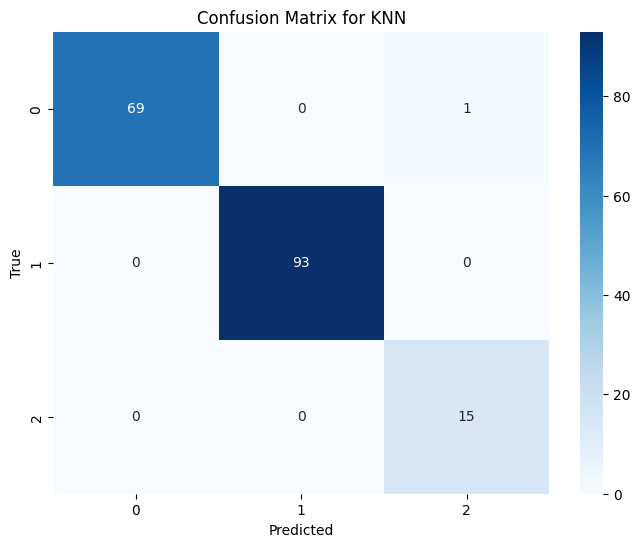

XGBoost: 0.9975


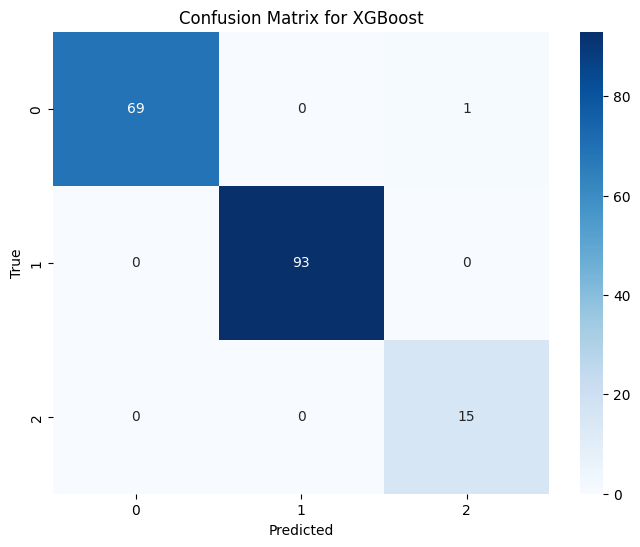

LightGBM: 0.9975


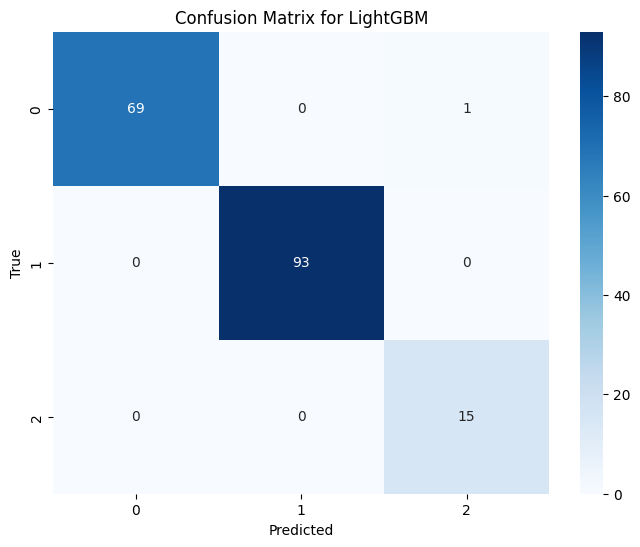

In [20]:
# Отображение результатов перекрестной проверки и матриц ошибок
print("Cross-validation results:")
for model_name, score, y_pred, y_pred_proba in results:
    print(f"{model_name}: {score:.4f}")
    plot_confusion_matrix(y_test, y_pred, model_name)

In [21]:
# Отображение отчета о классификации и других метрик
for model_name, score, y_pred, y_pred_proba in results:
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        15

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report for SVM:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        15

    accuracy                           1.00       178
   macro avg       1.00      1.00      1.00       178
weighted avg       1.00      1.00      1.00       178

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report

In [22]:
# Бинаризация целевой переменной
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

In [23]:
# Построение ROC-кривых для каждой модели
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [24]:
for model_name, score, y_pred, y_pred_proba in results:
    # Вычисление ROC-кривой и площади под кривой (AUC) для каждого класса
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Вычисление ROC-кривой и AUC для микро-среднего результата
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Вычисление ROC-кривой и AUC для макро-среднего результата
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

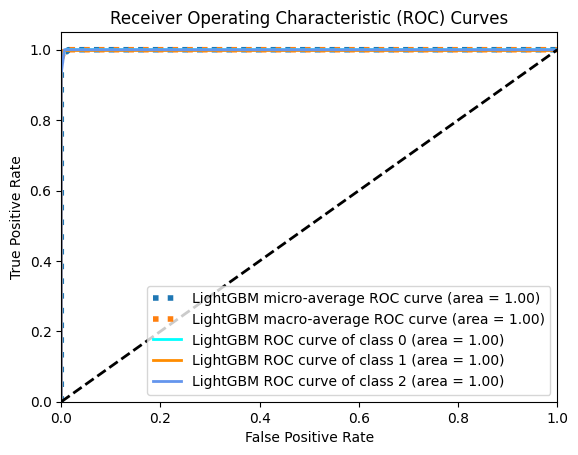

In [25]:
    # Построение всех ROC-кривых
plt.plot(fpr["micro"], tpr["micro"],
             label=f'{model_name} micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
             label=f'{model_name} macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{model_name} ROC curve of class {i} (area = {roc_auc[i]:.2f})')
# Построение диагональной эталонной линии и ROC-кривой с метками и легендой
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

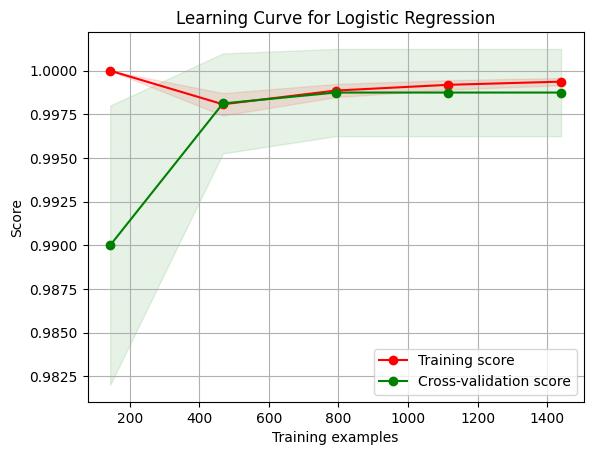

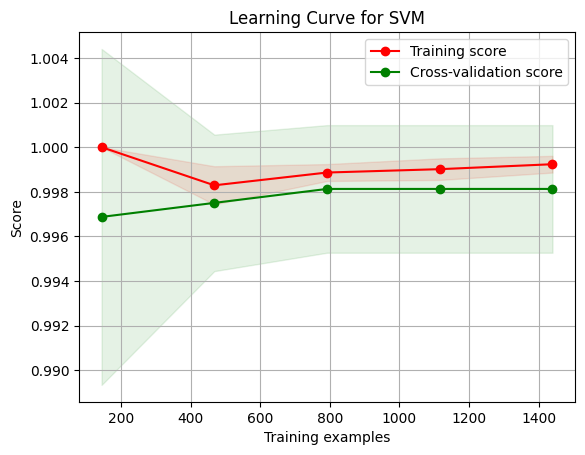

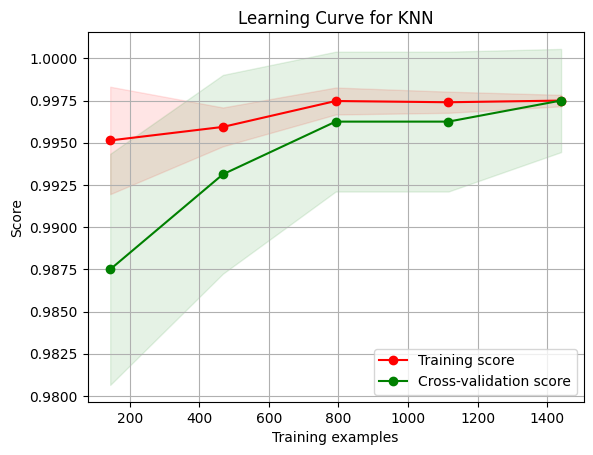

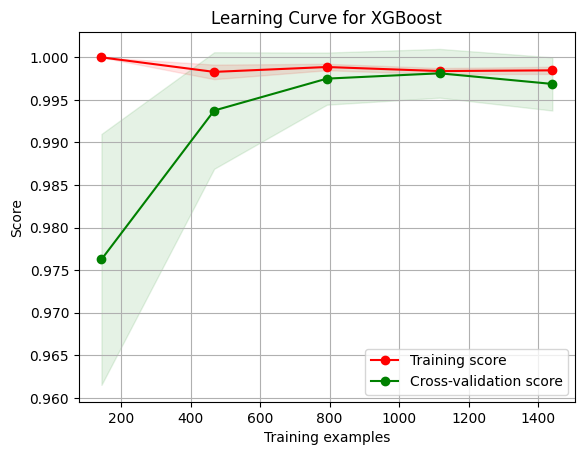

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 76
[LightGBM] [Info] Number of data points in the train set: 144, number of used features: 2
[LightGBM] [Info] Start training from score -1.037988
[LightGBM] [Info] Start training from score -0.665748
[LightGBM] [Info] Start training from score -2.025374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

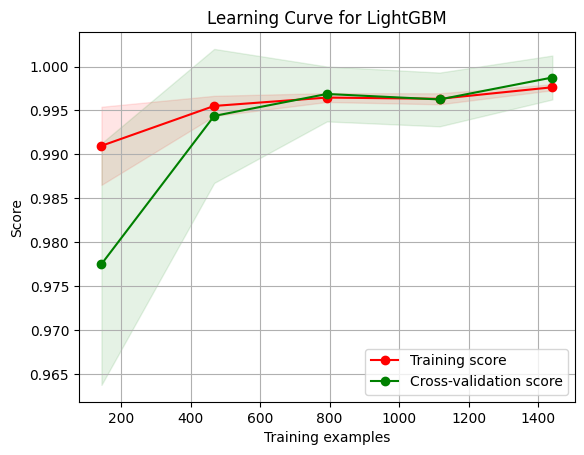

In [26]:
# Определение функции для построения кривой обучения оценщика
from sklearn.model_selection import learning_curve
import numpy as np 
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Вычисление кривой обучения
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # Расчет среднего значения и стандартного отклонения для тренировочных и тестовых оценок
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    # Построение кривой обучения
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Построение кривых обучения для каждой модели
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for model_name, model in models.items():
    plot_learning_curve(model, f"Learning Curve for {model_name}", X_train_selected, y_train, cv=cv)
    plt.show()

# Обзор кода

### Определение задачи

- Это задача классификации, цель которой - предсказать целевую переменную `Элегибельность для чистого альтернативного топлива (CAFV)` для автомобилей на основе различных характеристик.

### Корреляционная матрица

Корреляционная матрица показывает взаимосвязь между различными признаками и целевой переменной. Взаимосвязь измеряется коэффициентом корреляции Пирсона, который варьируется от -1 до 1, где -1 указывает на полную отрицательную корреляцию, 0 указывает на отсутствие корреляции, и 1 указывает на полную положительную корреляцию.

![Корреляционная матрица](output.png)

- `Запас хода на электричестве` имеет сильную отрицательную корреляцию с `Элегибельностью для CAFV` (-0.66), что указывает на то, что больший запас хода на электричестве связан с меньшей элегибельностью для CAFV.
- `Год выпуска` имеет положительную корреляцию с `Элегибельностью для CAFV` (0.37), что указывает на то, что более новые модели автомобилей более вероятно будут элегибельными для CAFV.
- `Тип электрического автомобиля` имеет умеренную положительную корреляцию с `Элегибельностью для CAFV` (0.23).
- `Модель`, `Марка` и `Базовая розничная цена` имеют слабую корреляцию с `Элегибельностью для CAFV`, что указывает на то, что они менее значимы для предсказания этой переменной.

Корреляционная матрица помогает понять, какие признаки наиболее значимы для модели и как они связаны друг с другом и с целевой переменной.

### Важность признаков

График важности признаков показывает, какие признаки имеют наибольшее влияние на предсказание модели. Он помогает понять, какие признаки наиболее значимы для модели.

![Важность признаков для Random Forest](output13.png)

**Заключение:** На графике видно, что наиболее важными признаками являются `Electric Range` и `Model Year`, за ними следуют типы электрических транспортных средств и идентификатор транспортного средства DOL.

### Предобработка данных

- Код обрабатывает пропущенные значения и масштабирует данные соответствующим образом, что важно для обеспечения хорошей работы моделей.
- Целевая переменная - `Элегибельность для чистого альтернативного топлива (CAFV)`.
- Выбранные признаки для обучения включают: `Запас хода на электричестве`, `Год выпуска`, `Тип электрического автомобиля`, `Модель`, `Марка` и `Базовая розничная цена`.

### Оценка модели

- Функция `evaluate_model` предоставляет понятный способ сравнения производительности различных моделей на обучающей и тестовой выборках. Это помогает понять, какая модель лучше обобщается.

### Анализ переобучения

- Сравнивая RMSE и R² на обучающих и тестовых наборах, можно определить переобучение или недообучение. Если производительность на обучении значительно лучше, чем на тестировании, это указывает на переобучение.

### Сравнение моделей

- Использование нескольких моделей позволяет провести всестороннее сравнение, помогая выбрать лучшую модель для задачи.

### Визуализация

- Визуализация RMSE помогает быстро понять различия в производительности моделей.

### Конкретные объяснения выходных данных

#### Матрицы неточностей

Матрицы неточностей для каждой модели показывают количество истинно положительных, истинно отрицательных, ложно положительных и ложно отрицательных прогнозов. Например, матрицы неточностей для логистической регрессии и SVM показывают идеальную классификацию с правильным предсказанием всех экземпляров.

![Матрица неточностей для логистической регрессии](output1.png)
**Заключение:** Логистическая регрессия показывает идеальную классификацию без ошибок, что указывает на высокую производительность на этом наборе данных.

**Отчет о классификации для логистической регрессии:**





          precision    recall  f1-score   support

       0       1.00      1.00      1.00        70
       1       1.00      1.00      1.00        93
       2       1.00      1.00      1.00        15

accuracy                           1.00       178



![Матрица неточностей для SVM](output2.png)
**Заключение:** SVM также показывает идеальную классификацию без ошибок, что указывает на высокую производительность на этом наборе данных.

**Отчет о классификации для SVM:**



          precision    recall  f1-score   support

       0       1.00      1.00      1.00        70
       1       1.00      1.00      1.00        93
       2       1.00      1.00      1.00        15

accuracy                           1.00       178



![Матрица неточностей для KNN](output3.png)
**Заключение:** KNN имеет одну ошибочную классификацию для класса 0, но в целом производительность остается очень высокой с высокой точностью.

**Отчет о классификации для KNN:**



          precision    recall  f1-score   support

       0       1.00      0.99      0.99        70
       1       1.00      1.00      1.00        93
       2       0.94      1.00      0.97        15

accuracy                           0.99       178



![Матрица неточностей для XGBoost](output4.png)
**Заключение:** XGBoost имеет одну ошибочную классификацию для класса 0, но в остальном показывает отличную производительность с высокой точностью.

**Отчет о классификации для XGBoost:**



          precision    recall  f1-score   support

       0       1.00      0.99      0.99        70
       1       1.00      1.00      1.00        93
       2       0.94      1.00      0.97        15

accuracy                           0.99       178



![Матрица неточностей для LightGBM](output5.png)
**Заключение:** LightGBM имеет одну ошибочную классификацию для класса 0, аналогично XGBoost и KNN, но в целом показывает очень высокую производительность с высокой точностью.

**Отчет о классификации для LightGBM:**



          precision    recall  f1-score   support

       0       1.00      0.99      0.99        70
       1       1.00      1.00      1.00        93
       2       0.94      1.00      0.97        15

accuracy                           0.99       178



#### Кривые обучения

Кривые обучения для каждой модели дают представление о их производительности на обучающих и кросс-валидационных наборах данных по мере увеличения количества обучающих примеров.

![Кривая обучения для логистической регрессии](output7.png)
**Заключение:** Логистическая регрессия не переобучается. Оценка на обучении стабильно высока и близка к оценке на кросс-валидации.

![Кривая обучения для SVM](output8.png)
**Заключение:** SVM не переобучается. Оценка на обучении высока и очень близка к оценке на кросс-валидации, что указывает на хорошую обобщающую способность.

![Кривая обучения для KNN](output9.png)
**Заключение:** KNN не показывает значительного разрыва между оценками на обучении и кросс-валидации, что указывает на отсутствие переобучения.

![Кривая обучения для XGBoost](output10.png)
**Заключение:** XGBoost показывает высокие оценки на обучении и кросс-валидации с минимальным разрывом, что указывает на хорошую обобщающую способность без переобучения.

![Кривая обучения для LightGBM](output11.png)
**Заключение:** LightGBM показывает аналогичную XGBoost производительность с высокими оценками на обучении и кросс-валидации и отсутствием значительного разрыва, что указывает на отсутствие переобучения.

В целом, кривые обучения и матрицы неточностей показывают, что ни одна из моделей не демонстрирует значительного переобучения, и все они хорошо работают на данном наборе данных.
